In [2]:

import os
import sys
import sklearn
import pip
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from PIL import Image

from pathlib import Path
# set figure size
plt.rcParams['figure.figsize'] = [14, 14]
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Requirements taken from https://www.tensorflow.org/install/pip#linux
python_version = sys.version
pip_version = pip.__version__
nvidia_smi_version = os.popen('nvidia-smi --query-gpu=driver_version --format=csv,noheader').read().strip()
cuda_version = os.popen('nvcc --version').read().split('\n')[3].split(',')[1].strip()
tensorflow_version = tf.__version__
physical_devices = tf.config.list_physical_devices('GPU')
num_gpus = len(physical_devices)
gpu_model = os.popen('nvidia-smi --query-gpu=name --format=csv,noheader').read().strip()

req_df = pd.DataFrame({
    'Package': ['Python', 'pip', 'nvidia-smi', 'cuda', 'tensorflow', 'GPUs'],
    'Required': ['3.7', '20.2', '450.51.06', '11.0', '2.3.0', '1'],
    'Installed': [python_version, pip_version, nvidia_smi_version, cuda_version, tensorflow_version, num_gpus]
})
               
print(f'All requiremetns met. Using TF with GPU: {gpu_model} ({num_gpus}x)')

pd.options.plotting.backend = "plotly"
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"

req_df


2024-02-01 13:21:44.798592: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 13:21:44.798696: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 13:21:44.829079: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-01 13:21:44.889971: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-01 13:21:45.793833: W tensorflow/compiler/tf2

All requiremetns met. Using TF with GPU: NVIDIA GeForce GTX 1660 (1x)


2024-02-01 13:21:47.066360: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-01 13:21:47.172444: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-01 13:21:47.172692: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

,Package,Required,Installed
0,Python,3.7,"3.9.17 (main, Jul 5 2023, 20:41:20) \n[GCC 11..."
1,pip,20.2,23.2.1
2,nvidia-smi,450.51.06,535.54.03
3,cuda,11.0,release 12.2
4,tensorflow,2.3.0,2.15.0
5,GPUs,1,1


In [3]:
from math import ceil
from sklearn.metrics import confusion_matrix

from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications import MobileNetV3Large, MobileNet

import keras
import keras.backend as K
from keras.models import Model, Sequential
from keras.utils import plot_model
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, accuracy_score
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import BinaryAccuracy, Precision, Recall
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.layers import Lambda, Input, GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation

keras.mixed_precision.set_global_policy("mixed_float16")

SEED = 14
IMG_SIZE = 224
CHANNELS = 3 
BATCH_SIZE = 8
AUTOTUNE = tf.data.experimental.AUTOTUNE
SHUFFLE_BUFFER_SIZE = 512

ALL_LABELS = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No_Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1660, compute capability 7.5


2024-02-01 13:21:47.317866: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [4]:
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color='blue', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [5]:

data =  pd.read_csv('ChestXray-14/sample/sample_labels_clean.csv')
data.head()

,image_path,labels,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No_Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,No Findings,classes_vector
0,/home/kayaba_attribution/Documents/UoL/FINAL_P...,"['Emphysema', 'Infiltration', 'Pleural_Thicken...",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0,[0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 0...
1,/home/kayaba_attribution/Documents/UoL/FINAL_P...,"['Cardiomegaly', 'Emphysema']",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,[0.0 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0...
2,/home/kayaba_attribution/Documents/UoL/FINAL_P...,['No_Finding'],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0...
3,/home/kayaba_attribution/Documents/UoL/FINAL_P...,['Atelectasis'],1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,[1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0...
4,/home/kayaba_attribution/Documents/UoL/FINAL_P...,"['Cardiomegaly', 'Edema', 'Effusion']",0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,[0.0 1.0 0.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0...


Make the required datasets:

+ train_df (70% data)
+ valid_df (15% data)
+ test_df (15% data)

stratify is used to ensure that the train and valid datasets have the same distribution of labels

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data['image_path'],
                                     data['classes_vector'],
                                     test_size=0.2, 
                                     random_state=SEED, 
                                     stratify=data['labels'].map(lambda x: x[:5]))


# valid_df, test_df = train_test_split(temp_df, 
#                                      test_size=0.2, 
#                                      random_state=SEED, 
#                                      stratify=temp_df['Finding Labels'].map(lambda x: x[:5]))


print(f'Train size: X: {len(X_train)}, y: {len(y_train)}')
print(f'Validation size: X: {len(X_val)}, y: {len(y_val)}')


Train size: X: 4484, y: 4484
Validation size: X: 1122, y: 1122


convert one-hot encoded vector str into a numpy array

In [7]:
y_train = np.array([np.fromstring(y[1:-1], sep=' ') for y in y_train])
y_val = np.array([np.fromstring(y[1:-1], sep=' ') for y in y_val])


In [8]:
for i in range(3):
    print("Train:", X_train[i][85:], y_train[i])

Train: 00000013_005.png [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Train: 00000013_026.png [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
Train: 00000017_001.png [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


case of multi-label classification, having an image directory that respects this structure is not possible because one observation can belong to multiple classes at the same time

we need to specify the dimensions of the image and keep 3 channels as they are needed for input of the pre-trained models on the ImageNet dataset

+ BATCH_SIZE = 256 # Big enough to measure an F1-score
+ AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
+ SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations

In [9]:
# Adapted from https://github.com/ashrefm/multi-label-soft-f1/blob/master/Multi-Label%20Image%20Classification%20in%20TensorFlow%202.0.ipynb
def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_png(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    # if is_training == True:
    #     # This is a small dataset, only load it once, and keep it in memory.
    #     dataset = dataset.cache()
    #     # Shuffle the data each buffer size
    #     dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [14]:
print(type(y_train))

<class 'numpy.ndarray'>


In [11]:
train_ds = create_dataset(X_train, y_train)
val_ds = create_dataset(X_val, y_val)

2024-02-01 13:21:47.437161: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-01 13:21:47.437438: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-01 13:21:47.437888: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [12]:
for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)
    
for f, l in val_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (8, 224, 224, 3)
Shape of labels array: (8, 15)
Shape of features array: (8, 224, 224, 3)
Shape of labels array: (8, 15)


In [13]:
assert False, "Stop here"

AssertionError: Stop here

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 93312)             0         
                                                                 
 dense (Dense)               (None, 15)                1

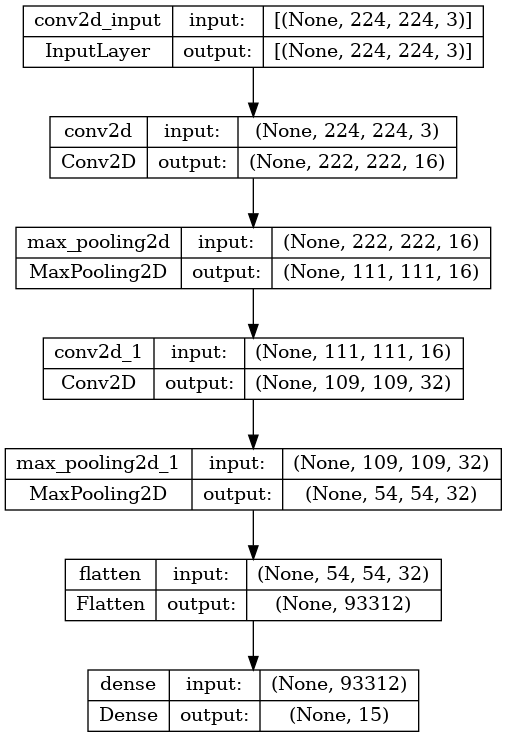

In [ ]:
Basic_CNN = Sequential([
    # First convolutional layer
    Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    # Second convolutional layer
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Flattening the results to feed into a dense layer
    Flatten(),

    # Output layer with sigmoid activation for multi-label classification
    Dense(15, activation='sigmoid')
])

plot_model(Basic_CNN, "Basic_CNN.png", show_shapes=True, show_layer_names=True)


In [ ]:
weight_path="{}_weights.best.hdf5".format('Basic_CNN')

# https://keras.io/api/callbacks/model_checkpoint/
checkpoint = ModelCheckpoint(
    weight_path,
    monitor='val_loss',
    verbose=1, 
    save_best_only=True,
    mode='min',
    save_weights_only = True)

# https://keras.io/api/callbacks/early_stopping/
earlystop = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=10)

# https://keras.io/api/callbacks/reduce_lr_on_plateau/
reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.8,
    patience=10,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=5,
    min_lr=0.0001)


callbacks_list = [checkpoint, earlystop, reduceLROnPlat]


Basic_CNN.compile(optimizer='adam', 
              loss='binary_crossentropy', 
                metrics=[
                    keras.metrics.BinaryAccuracy(name='accuracy'),
                    keras.metrics.Precision(name='precision'),
                    keras.metrics.Recall(name='recall'),
                    keras.metrics.AUC(name='auc'),
                    keras.metrics.AUC(name='prc', curve='PR')])

Basic_CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 93312)             0         
                                                                 
 dense (Dense)               (None, 15)                1

In [ ]:
start = time()
Basic_CNN_history = Basic_CNN.fit(
                    train_ds,
                    epochs=10,
                    validation_data=create_dataset(X_val, y_val),
                    callbacks=callbacks_list
                    )
print('\nTraining took {} sec'.format((time()-start)))

Epoch 1/10


2024-01-19 00:45:01.752587: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-19 00:45:07.199015: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f9e54003850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-19 00:45:07.199053: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660, Compute Capability 7.5
2024-01-19 00:45:07.207299: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1705643107.320032 3166023 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


561/561 [==============================] - ETA: 0s - loss: 0.2214 - accuracy: 0.9244 - precision: 0.5808 - recall: 0.3082 - auc: 0.8171 - prc: 0.4018
Epoch 1: val_loss improved from inf to 0.21719, saving model to Basic_CNN_weights.best.hdf5
561/561 [==============================] - 21s 24ms/step - loss: 0.2214 - accuracy: 0.9244 - precision: 0.5808 - recall: 0.3082 - auc: 0.8171 - prc: 0.4018 - val_loss: 0.2172 - val_accuracy: 0.9275 - val_precision: 0.6263 - val_recall: 0.3369 - val_auc: 0.8328 - val_prc: 0.4615 - lr: 0.0010
Epoch 2/10
560/561 [============================>.] - ETA: 0s - loss: 0.2077 - accuracy: 0.9284 - precision: 0.6322 - recall: 0.3224 - auc: 0.8475 - prc: 0.4532
Epoch 2: val_loss improved from 0.21719 to 0.21595, saving model to Basic_CNN_weights.best.hdf5
561/561 [==============================] - 9s 15ms/step - loss: 0.2076 - accuracy: 0.9284 - precision: 0.6325 - recall: 0.3226 - auc: 0.8476 - prc: 0.4535 - val_loss: 0.2160 - val_accuracy: 0.9266 - val_precis

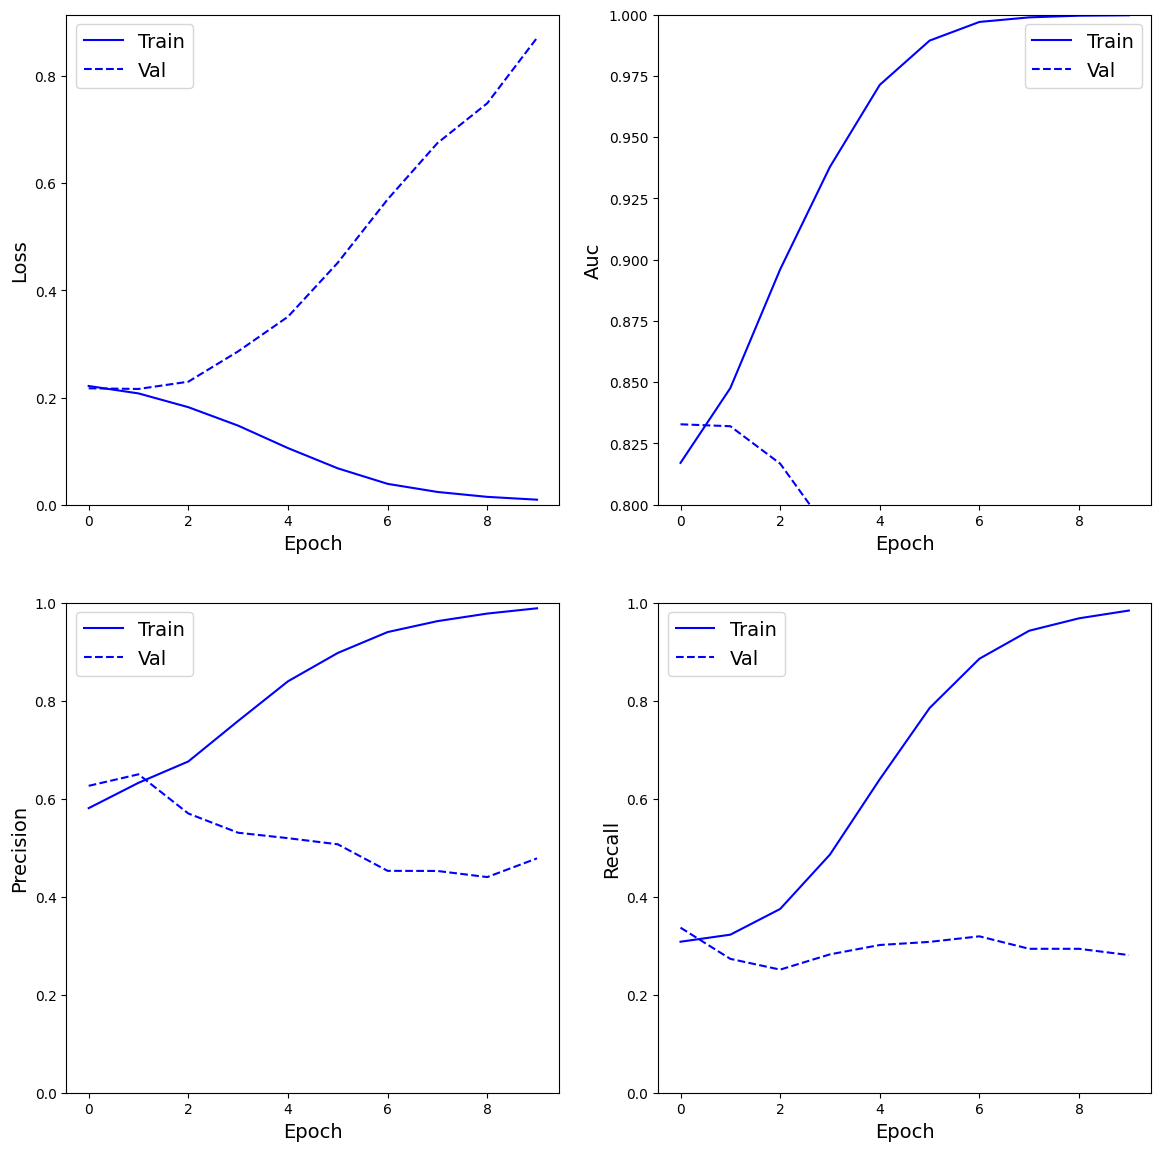

In [ ]:
plot_metrics(Basic_CNN_history)

In [ ]:
baseline_results = Basic_CNN.evaluate(val_ds,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(Basic_CNN.metrics_names, baseline_results):
  print(name, ': ', value)
print()


loss :  0.8710275888442993
accuracy :  0.9139037728309631
precision :  0.47831326723098755
recall :  0.2809624969959259
auc :  0.7089129686355591
prc :  0.2964073121547699



In [ ]:
print(classification_report(y_val, Basic_CNN.predict(create_dataset(X_val, y_val)).round(), target_names=ALL_LABELS))

141/141 [==============================] - 2s 8ms/step
                    precision    recall  f1-score   support

       Atelectasis       0.12      0.03      0.05       102
      Cardiomegaly       0.00      0.00      0.00        30
     Consolidation       0.00      0.00      0.00        45
             Edema       0.00      0.00      0.00        23
          Effusion       0.07      0.03      0.04       123
         Emphysema       0.00      0.00      0.00        32
          Fibrosis       0.00      0.00      0.00        18
            Hernia       0.00      0.00      0.00         4
      Infiltration       0.15      0.08      0.11       186
              Mass       0.23      0.05      0.09        57
        No_Finding       0.53      0.51      0.52       609
            Nodule       0.00      0.00      0.00        65
Pleural_Thickening       0.00      0.00      0.00        39
         Pneumonia       0.00      0.00      0.00        11
      Pneumothorax       0.05      0.01     

/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
MobileNet_base = MobileNet(
    weights="imagenet",
    input_shape=(224, 224, 3),
    include_top=False
)

# VGG16_base = VGG16(
#     weights="imagenet",
#     input_shape=(224, 224, 3),
#     include_top=False
# )

# ResNet50_base = ResNet50(
#     weights="imagenet",
#     input_shape=(224, 224, 3),
#     include_top=False
# )

In [ ]:
MobileNet_base.trainable = False
# VGG16_base.trainable = False
# ResNet50_base.trainable = False

LR = 1e-5 # Keep it small when transfer learning
EPOCHS = 30

## MobileNet_finetuned

In [ ]:

fine_inputs = keras.Input(shape=(224, 224, 3))
x = MobileNet_base(fine_inputs, training=False)
x = GlobalAveragePooling2D()(x)
fine_outputs = Dense(len(ALL_LABELS), activation="sigmoid")(x)
MobileNet_finetuned = keras.Model(fine_inputs, fine_outputs)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 15)                15375     
                                                                 
Total params: 3244239 (12.38 MB)
Trainable params: 15375 (60.06 KB)
Non-trainable params: 3228864 (12.32 MB)
_________________________________________________________________


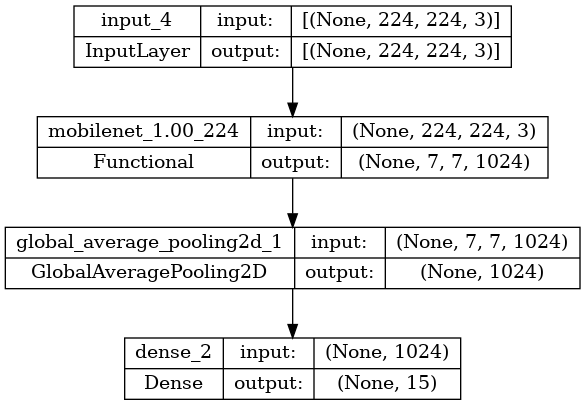

In [ ]:

# MobileNet_finetuned.load_weights('MobileNet_finetuned_weights.best.hdf5')

MobileNet_finetuned.compile(
                optimizer=keras.optimizers.Adam(learning_rate=LR),
                loss=keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=[
                    keras.metrics.BinaryAccuracy(name='accuracy'),
                    keras.metrics.Precision(name='precision'),
                    keras.metrics.Recall(name='recall'),
                    keras.metrics.AUC(name='auc'),
                    keras.metrics.AUC(name='prc', curve='PR')])

MobileNet_finetuned.summary()
plot_model(MobileNet_finetuned, "MobileNet_finetuned.png", show_shapes=True)

In [ ]:
weight_path="{}_weights.best.hdf5".format('MobileNet_finetuned')

# https://keras.io/api/callbacks/model_checkpoint/
checkpoint = ModelCheckpoint(
    weight_path,
    monitor='val_loss',
    verbose=1, 
    save_best_only=True,
    mode='min',
    save_weights_only = True)

# https://keras.io/api/callbacks/early_stopping/
earlystop = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=10)

# https://keras.io/api/callbacks/reduce_lr_on_plateau/
reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.8,
    patience=10,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=5,
    min_lr=0.0001)


callbacks_list = [earlystop, reduceLROnPlat]


In [ ]:



start = time()
MobileNet_finetuned_history = MobileNet_finetuned.fit(
                    train_ds,
                    epochs=5,
                    validation_data=create_dataset(X_val, y_val),
                    callbacks=callbacks_list
                    )
print('\nTraining took {} sec'.format((time()-start)))

Epoch 1/5


561/561 [==============================] - 24s 41ms/step - loss: 0.3615 - accuracy: 0.8546 - precision: 0.1599 - recall: 0.1779 - auc: 0.6773 - prc: 0.1405 - val_loss: 0.2733 - val_accuracy: 0.9150 - val_precision: 0.4871 - val_recall: 0.2279 - val_auc: 0.7486 - val_prc: 0.3085 - lr: 1.0000e-05
Epoch 2/5
561/561 [==============================] - 22s 39ms/step - loss: 0.2453 - accuracy: 0.9210 - precision: 0.5455 - recall: 0.2715 - auc: 0.7773 - prc: 0.3537 - val_loss: 0.2367 - val_accuracy: 0.9220 - val_precision: 0.5723 - val_recall: 0.2803 - val_auc: 0.7826 - val_prc: 0.3705 - lr: 1.0000e-05
Epoch 3/5
561/561 [==============================] - 22s 38ms/step - loss: 0.2257 - accuracy: 0.9236 - precision: 0.5777 - recall: 0.2864 - auc: 0.8046 - prc: 0.3884 - val_loss: 0.2278 - val_accuracy: 0.9237 - val_precision: 0.5939 - val_recall: 0.2887 - val_auc: 0.8008 - val_prc: 0.3923 - lr: 1.0000e-05
Epoch 4/5
561/561 [==============================] - 21s 38ms/step - loss: 0.2195 - accuracy

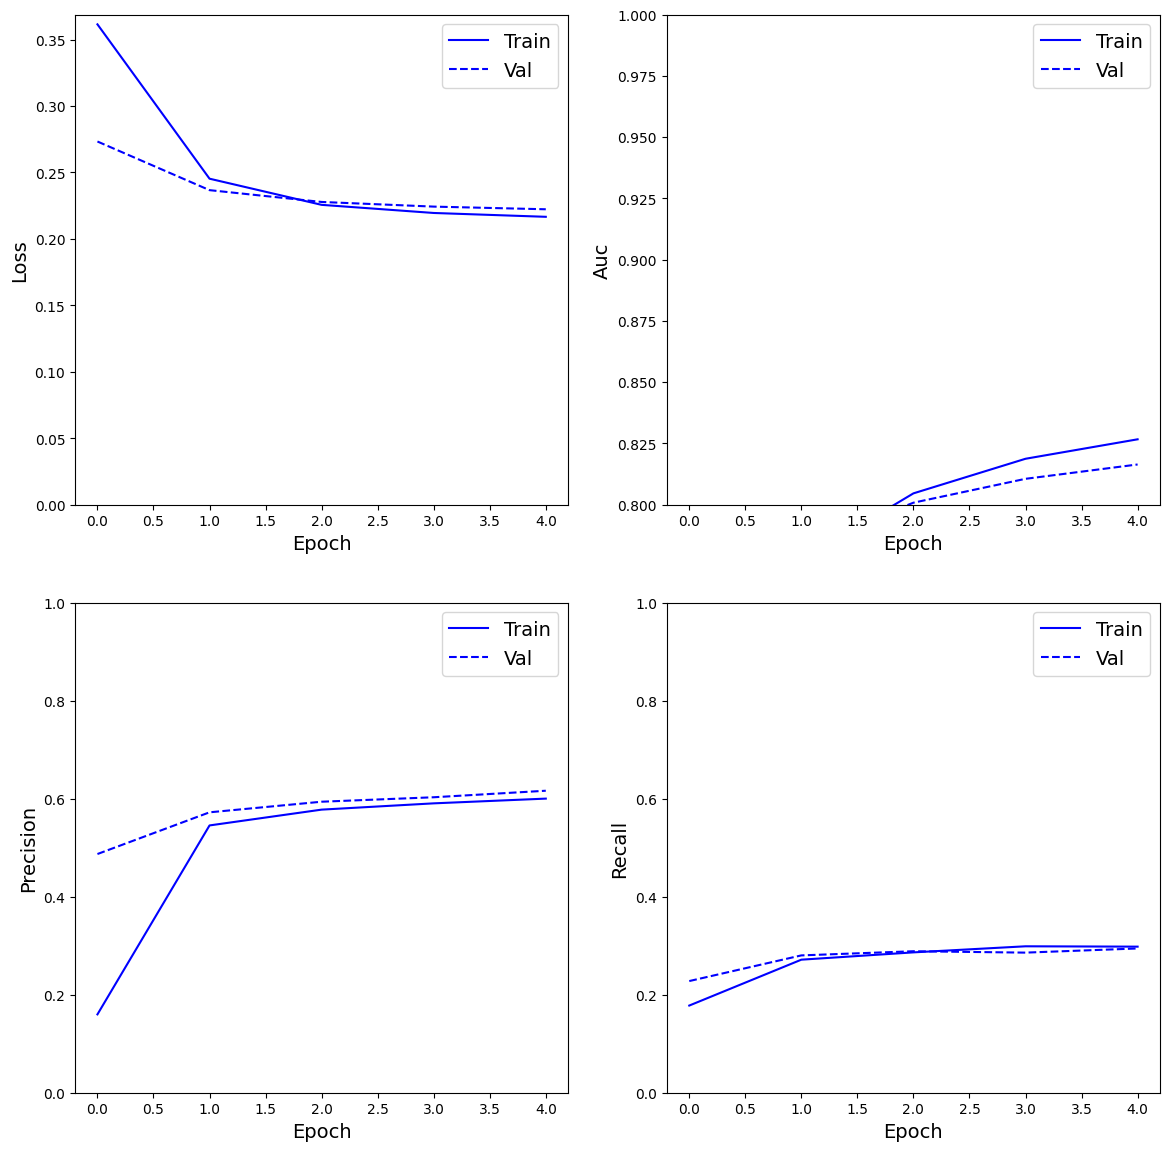

In [ ]:
plot_metrics(MobileNet_finetuned_history)

In [ ]:
baseline_results = MobileNet_finetuned.evaluate(val_ds,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(MobileNet_finetuned.metrics_names, baseline_results):
  print(name, ': ', value)
print()


loss :  0.2062927931547165
accuracy :  0.9291146993637085
precision :  0.6585014462471008
recall :  0.3234253227710724
auc :  0.857969343662262
prc :  0.47472742199897766



In [ ]:
print(classification_report(y_val, MobileNet_finetuned.predict(create_dataset(X_val, y_val)).round(), target_names=ALL_LABELS))

141/141 [==============================] - 5s 27ms/step
                    precision    recall  f1-score   support

       Atelectasis       0.00      0.00      0.00       102
      Cardiomegaly       0.00      0.00      0.00        30
     Consolidation       0.00      0.00      0.00        45
             Edema       0.00      0.00      0.00        23
          Effusion       0.00      0.00      0.00       123
         Emphysema       0.00      0.00      0.00        32
          Fibrosis       0.00      0.00      0.00        18
            Hernia       0.00      0.00      0.00         4
      Infiltration       0.00      0.00      0.00       186
              Mass       0.00      0.00      0.00        57
        No_Finding       0.55      0.60      0.57       609
            Nodule       0.00      0.00      0.00        65
Pleural_Thickening       0.00      0.00      0.00        39
         Pneumonia       0.00      0.00      0.00        11
      Pneumothorax       0.00      0.00    

/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 15)                15375     
                                                                 
Total params: 3244239 (12.38 MB)
Trainable params: 3222351 (12.29 MB)
Non-trainable params: 21888 (85.50 KB)
_________________________________________________________________


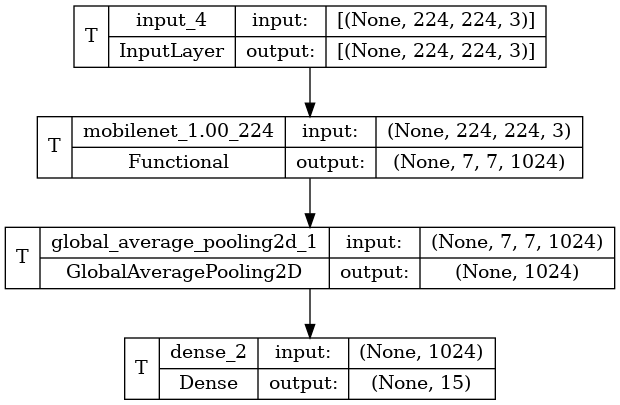

In [ ]:

MobileNet_base.trainable = True

MobileNet_finetuned.compile(
                optimizer=keras.optimizers.Adam(1e-5),
                loss=keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=[
                    keras.metrics.BinaryAccuracy(name='accuracy'),
                    keras.metrics.Precision(name='precision'),
                    keras.metrics.Recall(name='recall'),
                    keras.metrics.AUC(name='auc'),
                    keras.metrics.AUC(name='prc', curve='PR')])

MobileNet_finetuned.summary()
plot_model(MobileNet_finetuned, "MobileNet_finetuned_c.png", show_shapes=True, show_trainable=True)

In [ ]:
start = time()
MobileNet_finetuned_history = MobileNet_finetuned.fit(
                    train_ds,
                    epochs=5,
                    validation_data=create_dataset(X_val, y_val),
                    callbacks=callbacks_list
                    )
print('\nTraining took {} sec'.format((time()-start)))

Epoch 1/5
561/561 [==============================] - 64s 99ms/step - loss: 0.2078 - accuracy: 0.9284 - precision: 0.6405 - recall: 0.3055 - auc: 0.8472 - prc: 0.4592 - val_loss: 0.2055 - val_accuracy: 0.9308 - val_precision: 0.6944 - val_recall: 0.3135 - val_auc: 0.8593 - val_prc: 0.4826 - lr: 1.0000e-05
Epoch 2/5
561/561 [==============================] - 53s 94ms/step - loss: 0.1964 - accuracy: 0.9315 - precision: 0.6797 - recall: 0.3260 - auc: 0.8712 - prc: 0.5005 - val_loss: 0.2019 - val_accuracy: 0.9300 - val_precision: 0.7403 - val_recall: 0.2562 - val_auc: 0.8655 - val_prc: 0.4979 - lr: 1.0000e-05
Epoch 3/5
561/561 [==============================] - 53s 95ms/step - loss: 0.1907 - accuracy: 0.9326 - precision: 0.6940 - recall: 0.3326 - auc: 0.8815 - prc: 0.5226 - val_loss: 0.2017 - val_accuracy: 0.9304 - val_precision: 0.6516 - val_recall: 0.3680 - val_auc: 0.8669 - val_prc: 0.5002 - lr: 1.0000e-05
Epoch 4/5
561/561 [==============================] - 53s 95ms/step - loss: 0.1856 

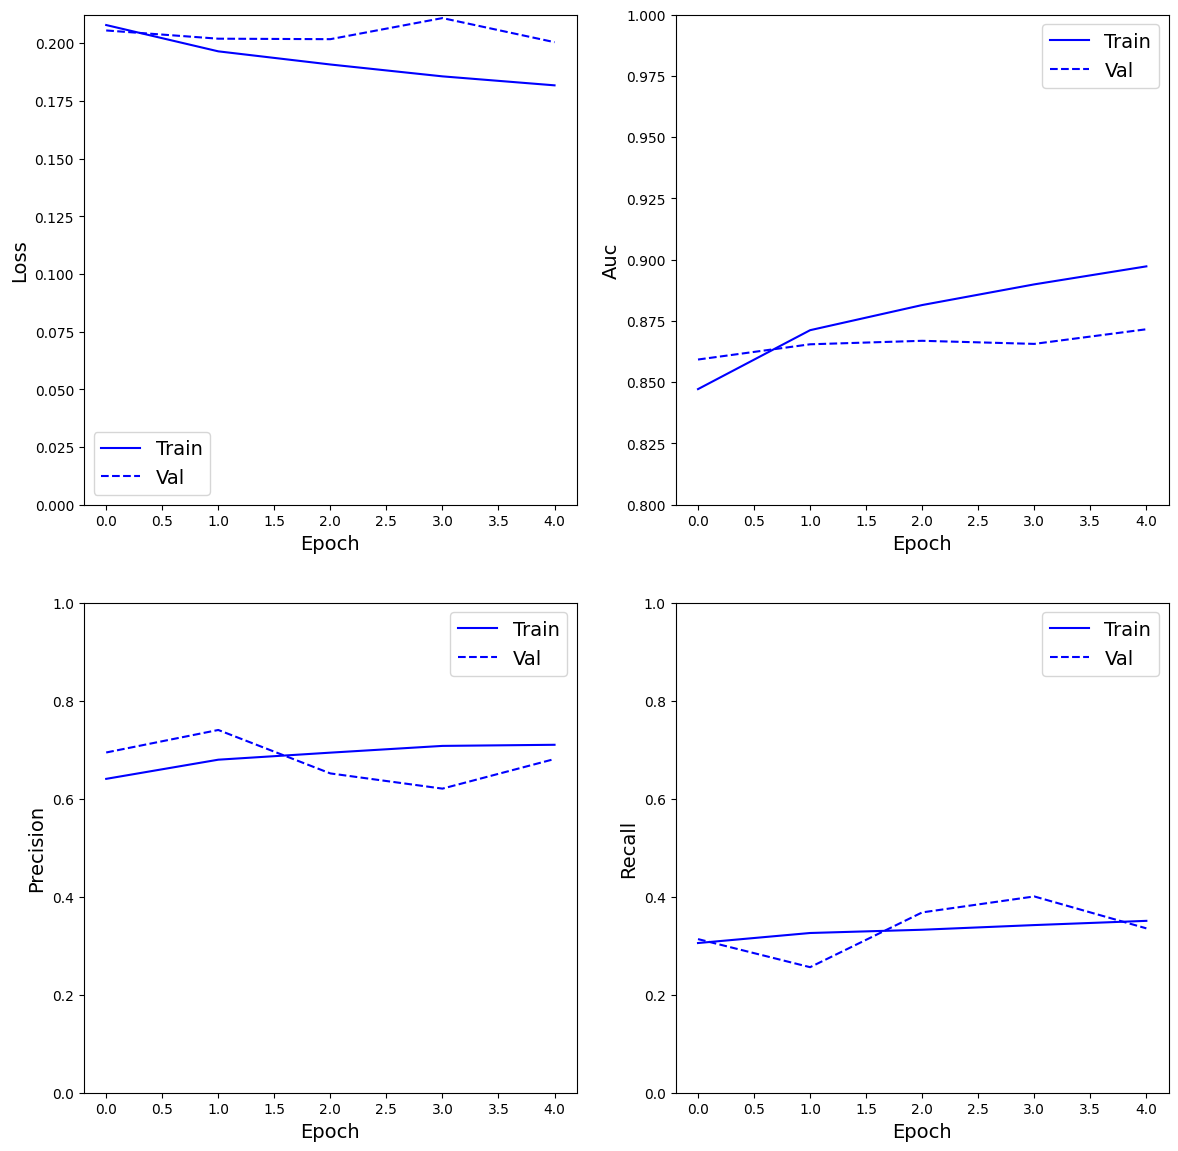

In [ ]:
plot_metrics(MobileNet_finetuned_history)

In [ ]:
baseline_results = MobileNet_finetuned.evaluate(val_ds,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(MobileNet_finetuned.metrics_names, baseline_results):
  print(name, ': ', value)
print()


loss :  0.20041312277317047
accuracy :  0.9310160279273987
precision :  0.681034505367279
recall :  0.3354564607143402
auc :  0.8716174364089966
prc :  0.5056691765785217



In [ ]:
print(classification_report(y_val, MobileNet_finetuned.predict(create_dataset(X_val, y_val)).round(), target_names=ALL_LABELS))

141/141 [==============================] - 5s 29ms/step
                    precision    recall  f1-score   support

       Atelectasis       0.00      0.00      0.00       102
      Cardiomegaly       0.00      0.00      0.00        30
     Consolidation       0.00      0.00      0.00        45
             Edema       0.00      0.00      0.00        23
          Effusion       0.00      0.00      0.00       123
         Emphysema       0.00      0.00      0.00        32
          Fibrosis       0.00      0.00      0.00        18
            Hernia       0.00      0.00      0.00         4
      Infiltration       0.36      0.02      0.04       186
              Mass       0.00      0.00      0.00        57
        No_Finding       0.55      0.61      0.58       609
            Nodule       0.00      0.00      0.00        65
Pleural_Thickening       0.00      0.00      0.00        39
         Pneumonia       0.00      0.00      0.00        11
      Pneumothorax       0.00      0.00    

/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def print_cmx(y_true, y_pred):
    labels = ALL_LABELS
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    plt.figure(figsize = (10,7))
    sns.heatmap(df_cmx, annot=True)
    plt.show()

In [ ]:
from utils import *

ALL_LABELS = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No_Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

grid_bce = perf_grid(val_ds, y_val, ALL_LABELS, MobileNet_finetuned)

141/141 [==============================] - 4s 27ms/step


In [ ]:
grid_bce.head()

,id,label,freq,threshold,tp,fn,fp,precision,recall,f1
0,0,Atelectasis,0.09,0.00,102,0,1020,0.090909,1.000000,0.166667
1,0,Atelectasis,0.09,0.01,102,0,1019,0.090990,1.000000,0.166803
2,0,Atelectasis,0.09,0.02,100,2,988,0.091912,0.980392,0.168067
3,0,Atelectasis,0.09,0.03,87,15,910,0.087262,0.852941,0.158326
4,0,Atelectasis,0.09,0.04,79,23,819,0.087973,0.774510,0.158000


In [ ]:
import seaborn as sns
# Get the maximum F1-score for each label when using the second model and varying the threshold
max_perf = grid_bce.groupby(['id', 'label', 'freq'])[['f1']].max().sort_values('f1', ascending=False).reset_index()
max_perf.rename(columns={'f1':'f1max_bce'}, inplace=True)
max_perf.style.background_gradient(subset=['freq', 'f1max_bce'], cmap=sns.light_palette("lightgreen", as_cmap=True))

,id,label,freq,f1max_bce
0,10,No_Finding,0.540000,0.703640
1,8,Infiltration,0.170000,0.284404
2,4,Effusion,0.110000,0.217573
3,0,Atelectasis,0.090000,0.168067
4,2,Consolidation,0.040000,0.152672
5,6,Fibrosis,0.020000,0.131148
6,14,Pneumothorax,0.060000,0.127807
7,11,Nodule,0.060000,0.117514
8,9,Mass,0.050000,0.115385
9,12,Pleural_Thickening,0.030000,0.080972


In [ ]:
print("Correlation between label frequency and optimal F1 with bce: %.2f" %max_perf['freq'].corr(max_perf['f1max_bce']))


Correlation between label frequency and optimal F1 with bce: 0.99


####  Data augmentation generator in order to avoid overfitting

In [ ]:
data_gen = ImageDataGenerator(horizontal_flip = True, 
                              rotation_range=5,
                              samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1)

In [ ]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, batch_size, target_size=IMG_SIZE):
    # Check if the first image path is valid
    first_image_path = in_df[path_col].iloc[0]
    if not os.path.isfile(first_image_path):
        raise ValueError(f"First image not found at path: {first_image_path}")

    # Create a generator for the images only
    df_gen = img_data_gen.flow_from_dataframe(
        dataframe=in_df,
        directory=None,
        x_col=path_col,
        y_col=None,  # Set to None as we'll handle labels separately
        target_size=target_size,
        color_mode='rgb',
        class_mode=None,  # We handle the labels ourselves
        batch_size=batch_size,
        shuffle=True  # Typically set to True for training data
    )

    # Extract labels from the DataFrame and convert them to a numpy array
    labels = np.array([np.fromstring(y[1:-1], sep=' ') for y in in_df[y_col].values])

    # Create a generator that yields image and label pairs
    def generator():
        for x_batch in df_gen:
            # Calculate the index for the current batch
            idx = (df_gen.batch_index - 1) * df_gen.batch_size
            idx = idx % len(in_df)  # Handle wrap-around at the end of an epoch

            # Fetch the corresponding labels for the current batch
            y_batch = labels[idx: idx + batch_size]

            # Adjust the size of y_batch for the last batch
            y_batch = y_batch[:x_batch.shape[0]]

            yield x_batch, y_batch

    return generator()


In [ ]:
train_gen = flow_from_dataframe(data_gen, train_df, 
                             path_col = 'image_path',
                             y_col = 'classes_vector', 
                             batch_size = 16,
                             target_size = IMG_SIZE,
                            )

valid_gen = flow_from_dataframe(data_gen, valid_df, 
                             path_col = 'image_path',
                            y_col = 'classes_vector', 
                            target_size = IMG_SIZE,
                            batch_size = 32)

test_X, test_Y = next(flow_from_dataframe(data_gen, 
                               test_df, 
                             path_col = 'image_path',
                            y_col = 'classes_vector',
                            batch_size = 128))

def get_classes(vector):
    return [ALL_LABELS[i] for i, x in enumerate(vector) if x == (1)]


Found 3924 validated image filenames.
Found 841 validated image filenames.
Found 841 validated image filenames.


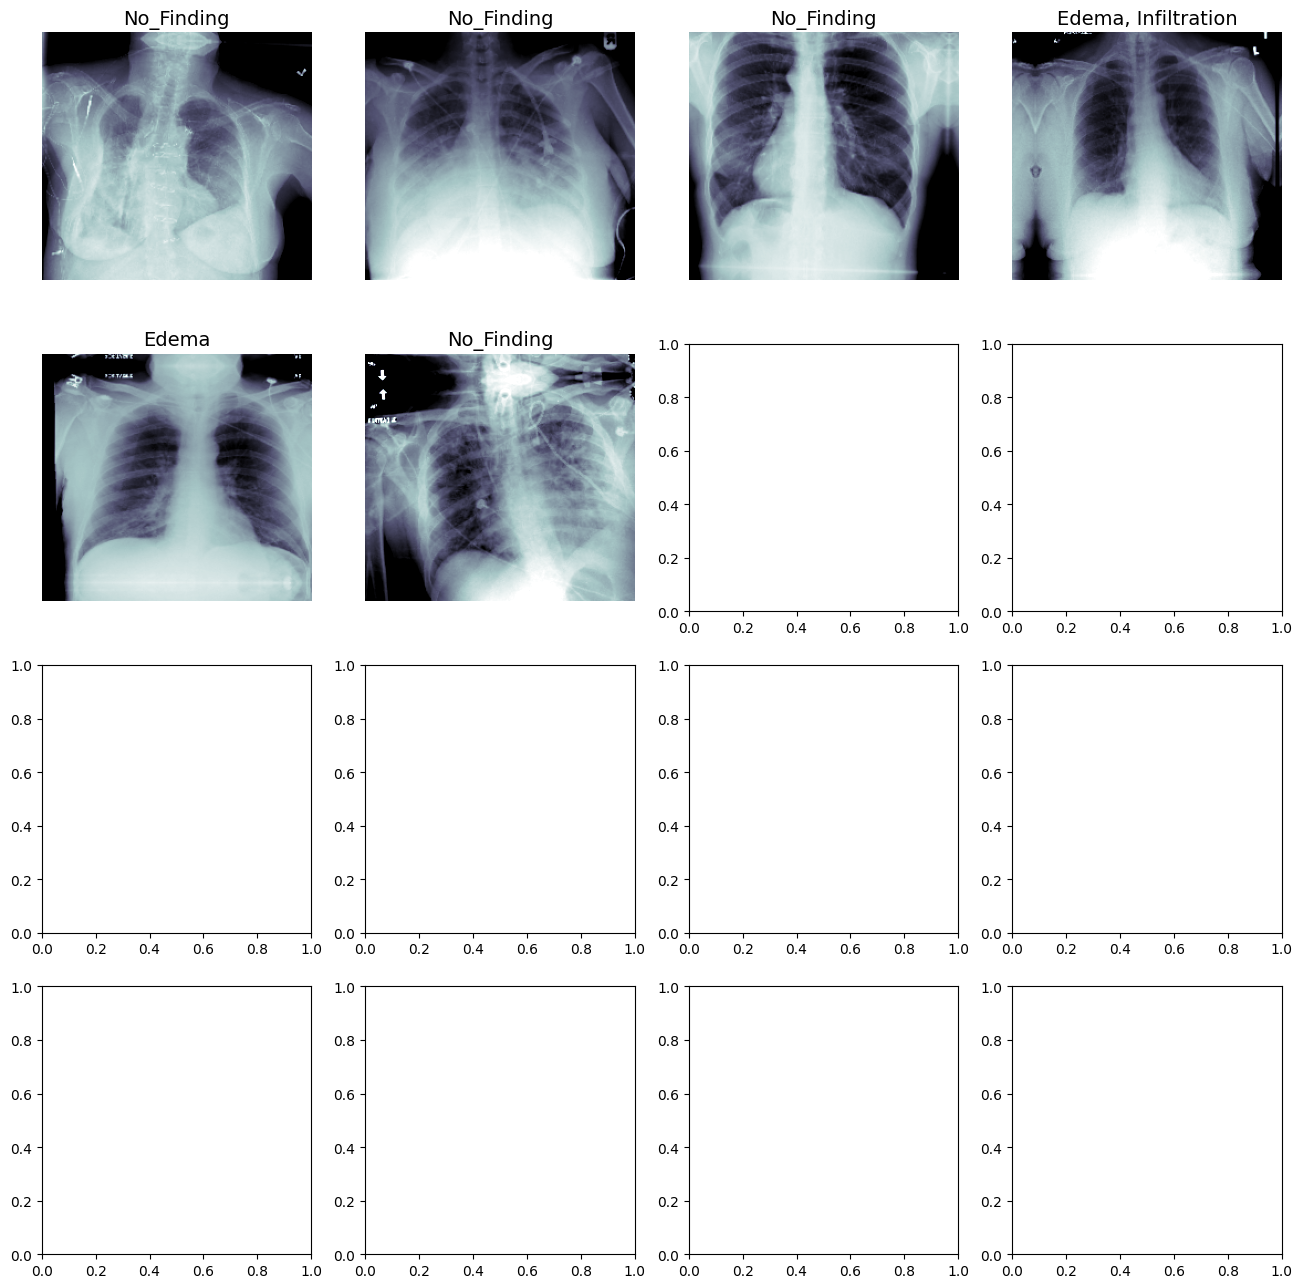

In [ ]:
train_X, train_Y = next(train_gen)

fig, m_axs = plt.subplots(4, 4, figsize=(16, 16))
m_axs = m_axs.flatten()

for (c_x, c_y, c_ax) in zip(train_X, train_Y, m_axs):
    c_ax.imshow(c_x[:, :, 0], cmap='bone', vmin=-1.5, vmax=1.5)
    class_labels = get_classes(c_y)
    c_ax.set_title(', '.join(class_labels))
    c_ax.axis('off')


plt.show()

In [ ]:
print(f'train_X.shape: {train_X.shape}, train_Y.shape: {train_Y.shape}')

train_X.shape: (6, 224, 244, 3), train_Y.shape: (6, 15)


In this second approach, the custom Lambda layer expands and repeats the single grayscale channel to create a 3-channel input for the ResNet50 model.

The Lambda layer uses K.concatenate to replicate the single channel three times along the last axis (the channel axis). This ensures that the expanded tensor has the correct shape of (None, 224, 224, 3).

In [ ]:

ResNet50_base = ResNet50(
    weights="imagenet",
    input_shape=(224, 224, 3),
    include_top=False
)

# ResNet50_base.summary()

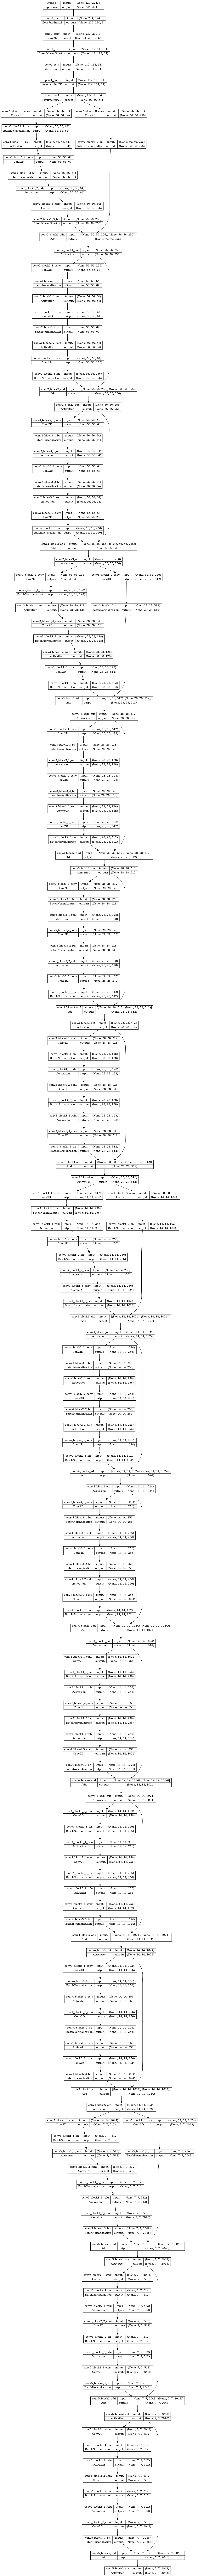

In [ ]:
plot_model(ResNet50_base, "ResNet50_base.png", show_shapes=True, expand_nested=True)

In [ ]:
ResNet50_base.trainable = False

In [ ]:
resnet_fine_inputs = keras.Input(shape=(224, 224, 3))

x = ResNet50_base(resnet_fine_inputs, training=False)
x = GlobalAveragePooling2D()(x)

resnet_fine_outputs = Dense(len(ALL_LABELS), activation="sigmoid")(x)

ResNet50_finetuned = keras.Model(resnet_fine_inputs, resnet_fine_outputs)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 15)                30735     
                                                                 
Total params: 23618447 (90.10 MB)
Trainable params: 30735 (120.06 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


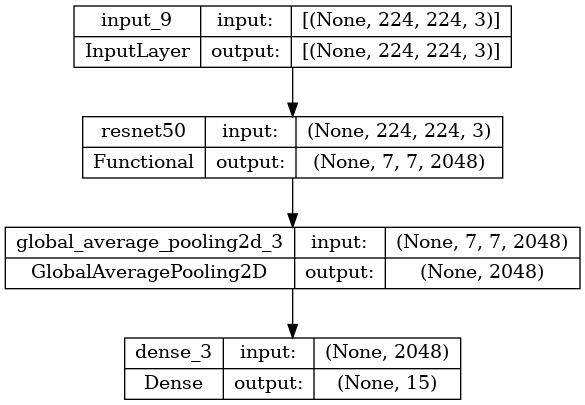

In [ ]:
ResNet50_finetuned.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[BinaryAccuracy(), Precision(), Recall(), ])

ResNet50_finetuned.summary()
plot_model(ResNet50_finetuned, "ResNet50_finetuned.png", show_shapes=True)

In [ ]:
weight_path="{}_weights.best.hdf5".format('ResNet50_finetuned')

# https://keras.io/api/callbacks/model_checkpoint/
checkpoint = ModelCheckpoint(
    weight_path,
    monitor='val_loss',
    verbose=1, 
    save_best_only=True,
    mode='min',
    save_weights_only = True)

# https://keras.io/api/callbacks/early_stopping/
earlystop = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=10)

# https://keras.io/api/callbacks/reduce_lr_on_plateau/
reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.8,
    patience=10,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=5,
    min_lr=0.0001)


callbacks_list = [checkpoint, earlystop, reduceLROnPlat]
                 

In [ ]:



ResNet50_finetuned.fit(train_gen,
                       validation_data=(test_X, test_Y),
                       epochs=1,
                       callbacks=callbacks_list,
                       steps_per_epoch=ceil(len(train_df) / 4)
                       )

166/981 [====>.........................] - ETA: 1:00 - loss: 0.2378 - binary_accuracy: 0.9134 - precision_4: 0.4701 - recall_4: 0.2833

KeyboardInterrupt: 

In [ ]:
VGG16_base = VGG16(
    weights="imagenet",
    input_shape=(224, 224, 3),
    include_top=False
)

2024-01-18 04:40:22.704836: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-18 04:40:22.705471: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-18 04:40:22.705673: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

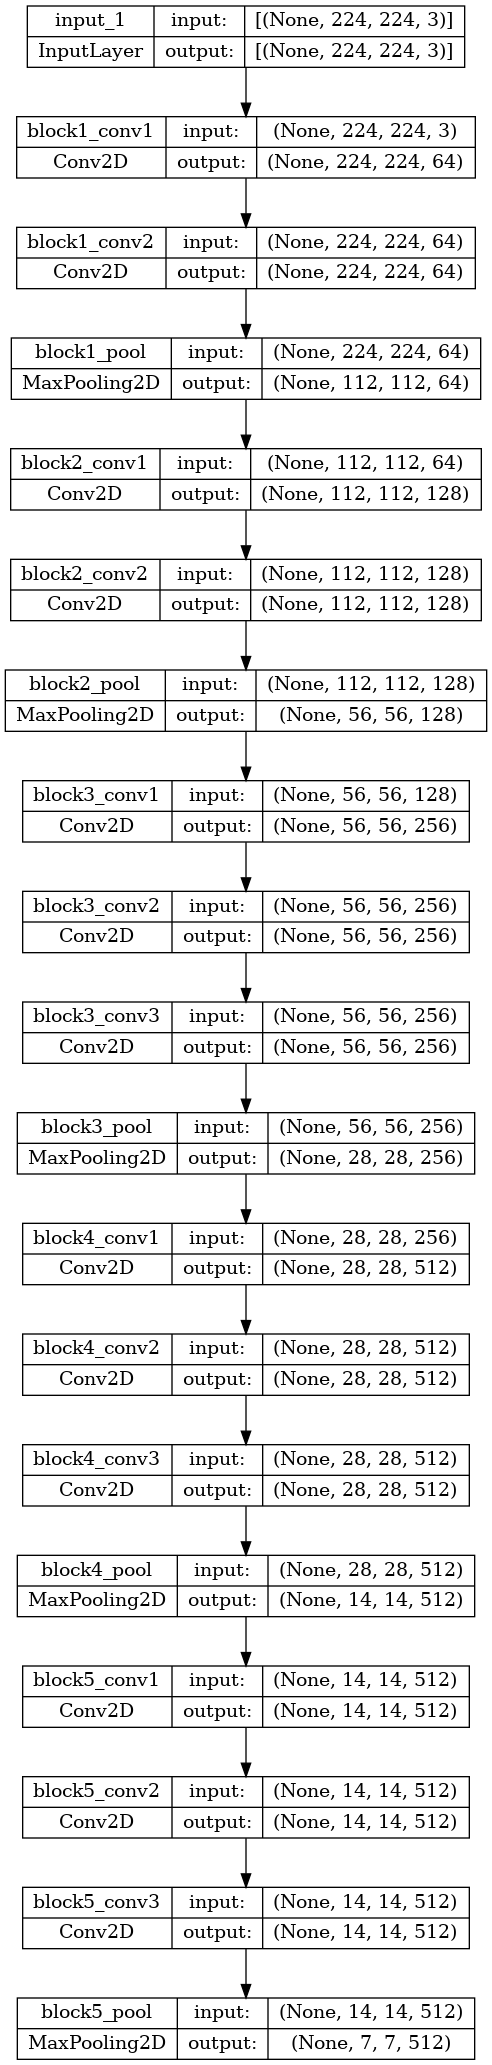

In [ ]:
plot_model(VGG16_base, "VGG16_base.png", show_shapes=True, expand_nested=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 15)                7695      
                                                                 
Total params: 14722383 (56.16 MB)
Trainable params: 7695 (30.06 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


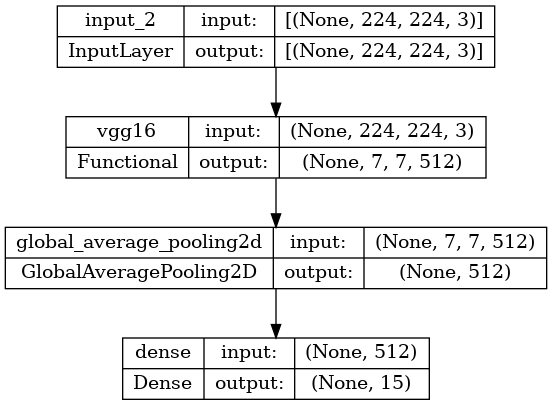

In [ ]:
VGG16_base.trainable = False

vgg_fine_inputs = keras.Input(shape=(224, 224, 3))
x = VGG16_base(vgg_fine_inputs, training=False)
x = GlobalAveragePooling2D()(x)
vgg_fine_outputs = Dense(len(ALL_LABELS), activation="sigmoid")(x)

VGG16_finetuned = keras.Model(vgg_fine_inputs, vgg_fine_outputs)

VGG16_finetuned.compile(optimizer=keras.optimizers.Adam(),
                loss=keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=[BinaryAccuracy(), Precision(), Recall(), ])

VGG16_finetuned.summary()
plot_model(VGG16_finetuned, "VGG16_finetuned.png", show_shapes=True)

In [ ]:
from math import ceil

os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"

VGG16_finetuned.fit(train_gen,
                    validation_data=(test_X, test_Y),
                    epochs=1,
                    callbacks=callbacks_list,
                    steps_per_epoch=ceil(len(train_df) / 4)
                    )

981/981 [==============================] - ETA: 0s - loss: 0.2165 - binary_accuracy: 0.9214 - precision: 0.5413 - recall: 0.3498

2024-01-18 05:11:21.278215: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op model/vgg16/block1_conv1/Relu
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-01-18 05:11:21.278272: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-01-18 05:11:21.278295: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 185, Chunks in use: 175. 46.2KiB allocated for chunks. 43.8KiB in use in bin. 15.1KiB client-requested in use in bin.
2024-01-18 05:11:21.278303: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 64, Chunks in use: 64. 32.0KiB allocated for chunks. 32.0KiB in use in bin. 31.9KiB client-requested in use in b

ResourceExhaustedError: Graph execution error:

Detected at node model/vgg16/block1_conv1/Relu defined at (most recent call last):
  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 736, in start

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 505, in process_one

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 740, in execute_request

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 546, in run_cell

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code

  File "/tmp/ipykernel_3110619/3224295017.py", line 3, in <module>

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1856, in fit

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 2296, in evaluate

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 4108, in run_step

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 2066, in test_function

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 2049, in step_function

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 2037, in run_step

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1917, in test_step

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py", line 321, in call

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/activations.py", line 306, in relu

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/backend.py", line 5395, in relu

OOM when allocating tensor with shape[32,64,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/vgg16/block1_conv1/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_test_function_7996]

In [ ]:
from resnet import resnet18

inputs = keras.Input(shape=(None, None, 3))
outputs = resnet18(inputs)
model = keras.Model(inputs, outputs)


/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_5[0][0]']             
                                                                                                  
 conv1 (Conv2D)              (None, None, None, 64)       9408      ['conv1_pad[0][0]']           
                                                                                                  
 bn1 (BatchNormalization)    (None, None, None, 64)       256       ['conv1[0][0]']               
                                                                                            

In [ ]:
MobileNet_base = MobileNet(
    weights="imagenet",
    input_shape=(224, 224, 3),
    include_top=False
)

In [ ]:
# plot_model(MobileNet_base, "MobileNet_base.png", show_shapes=True, expand_nested=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 15)                15375     
                                                                 
Total params: 3244239 (12.38 MB)
Trainable params: 15375 (60.06 KB)
Non-trainable params: 3228864 (12.32 MB)
_________________________________________________________________


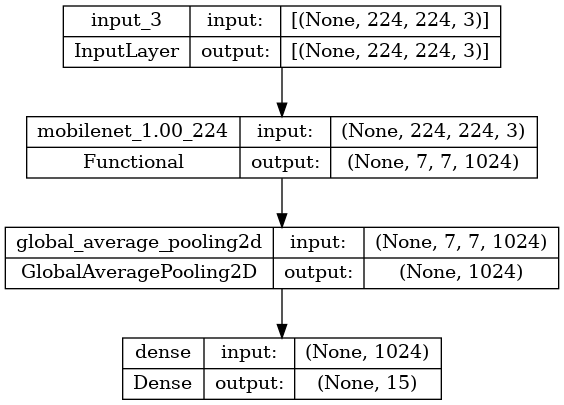

In [ ]:
MobileNet_base.trainable = False

mobilenet_fine_inputs = keras.Input(shape=(224, 224, 3))
x = MobileNet_base(mobilenet_fine_inputs, training=False)
x = GlobalAveragePooling2D()(x)
mobilenet_fine_outputs = Dense(len(ALL_LABELS), activation="sigmoid")(x)

MobileNetV3Large_finetuned = keras.Model(mobilenet_fine_inputs, mobilenet_fine_outputs)

MobileNetV3Large_finetuned.compile(optimizer=keras.optimizers.Adam(),
                loss=keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=[BinaryAccuracy(), Precision(), Recall(), ])

MobileNetV3Large_finetuned.summary()
plot_model(MobileNetV3Large_finetuned, "MobileNetV3Large_finetuned.png", show_shapes=True)

In [ ]:
MobileNetV3Large_finetuned.fit(train_gen,
                    validation_data=valid_gen,
                    epochs=2,
                    callbacks=callbacks_list,
                    steps_per_epoch=ceil(len(train_df) / 6)
                    )

Epoch 1/2
654/654 [==============================] - ETA: 0s - loss: 0.2342 - binary_accuracy: 0.9201 - precision: 0.5375 - recall: 0.2700

ValueError: in user code:

    File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 2066, in test_function  *
        return step_function(self, iterator)
    File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 2049, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 2037, in run_step  **
        outputs = model.test_step(data)
    File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1917, in test_step
        y_pred = self(x, training=False)
    File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(32, 224, 244, 3)


In [ ]:
MobileNetV3Large_base.trainable = True
MobileNetV3Large_finetuned.summary(show_trainable=True)

Model: "model_3"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         Y          
                                                                            
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   Y          
 al)                                                                        
                                                                            
 global_average_pooling2d_2  (None, 960)               0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dense_2 (Dense)             (None, 15)                14415     Y          
                                                                            
Total params: 3010767 (11.49 MB)
Trainable params: 2986367 

In [ ]:
MobileNetV3Large_finetuned.compile(optimizer=keras.optimizers.Adam(1e-5),
                loss=keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=[BinaryAccuracy(), Precision(), Recall(), ])

MobileNetV3Large_finetuned.fit(train_gen,
                    validation_data=(test_X, test_Y),
                    epochs=1,
                    callbacks=callbacks_list,
                    steps_per_epoch=ceil(len(train_df) / 4)
                    )

2024-01-18 05:40:25.391656: W tensorflow/core/kernels/conv_ops_gpu.cc:322] None of the algorithms provided by cuDNN frontend heuristics worked; trying fallback algorithms.  Conv: batch: 4
in_depths: 64
out_depths: 64
in: 113
in: 113
filter: 3
filter: 3
filter: 1
dilation: 1
dilation: 1
stride: 2
stride: 2
padding: 0
padding: 0
dtype: DT_HALF
group_count: 64
device_identifier: "sm_7.5 with 6216876032B RAM, 22 cores, 1830000KHz clock, 4001000KHz mem clock, 1572864B L2$"
version: 3

2024-01-18 05:40:25.392878: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at conv_grad_input_ops.cc:386 : NOT_FOUND: No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine eng1{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16978176 bytes.
  Profiling failure on CUDNN engine eng25{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16978176 bytes.
  Profiling failure on CUDNN engine eng0{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocat

NotFoundError: Graph execution error:

Detected at node gradient_tape/model_3/MobilenetV3large/expanded_conv_1/depthwise/depthwise/DepthwiseConv2dNativeBackpropInput defined at (most recent call last):
  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 736, in start

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 505, in process_one

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 740, in execute_request

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 546, in run_cell

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code

  File "/tmp/ipykernel_3110619/3496465939.py", line 5, in <module>

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1154, in train_step

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/optimizers/optimizer.py", line 543, in minimize

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/mixed_precision/loss_scale_optimizer.py", line 1259, in compute_gradients

  File "/home/kayaba_attribution/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/optimizers/optimizer.py", line 276, in compute_gradients

No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine eng1{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16978176 bytes.
  Profiling failure on CUDNN engine eng25{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16978176 bytes.
  Profiling failure on CUDNN engine eng0{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine eng15{k2=4,k4=1,k5=3,k6=3,k7=2,k20=0}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 20382976 bytes.
  Profiling failure on CUDNN engine eng5{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 18387200 bytes.
  Profiling failure on CUDNN engine eng4{k11=2}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 46011008 bytes.
  Profiling failure on CUDNN engine eng50{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 26735232 bytes.
	 [[{{node gradient_tape/model_3/MobilenetV3large/expanded_conv_1/depthwise/depthwise/DepthwiseConv2dNativeBackpropInput}}]] [Op:__inference_train_function_202827]